In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("test").getOrCreate()
sc = spark.sparkContext

In [2]:
stock_1 = spark.read.csv("../../stock_market_data/sp500/csv/AAPL.csv", inferSchema=True, header=True)

In [3]:
stock_1.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: long (nullable = true)
 |-- High: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adjusted Close: double (nullable = true)



In [4]:
from pyspark.sql import functions as F 
close_data = stock_1.select(F.collect_list('Close').alias('Close Price'))
low_data = stock_1.select(F.collect_list('Low').alias('Low Price'))
open_data = stock_1.select(F.collect_list('Open').alias('Open Price'))
volumn_data = stock_1.select(F.collect_list('Volume').alias('Transaction Volume'))
high_data = stock_1.select(F.collect_list('High').alias('High Price'))
adjusted_close_data = stock_1.select(F.collect_list('Adjusted Close').alias('Adjusted Close Price'))

In [5]:
close_price_array = close_data.first()['Close Price']
low_price_array = low_data.first()['Low Price']
open_price_array = open_data.first()['Open Price']
transaction_volume_array = volumn_data.first()['Transaction Volume']
transaction_volume_array = list(map(float, transaction_volume_array))
high_price_array = high_data.first()['High Price']
adjusted_close_price_array = adjusted_close_data.first()['Adjusted Close Price']

In [6]:
date_array = stock_1.select(F.collect_list('Date').alias('Date')).first()['Date']

In [7]:
days = [i for i in range(1, len(date_array) + 1)]

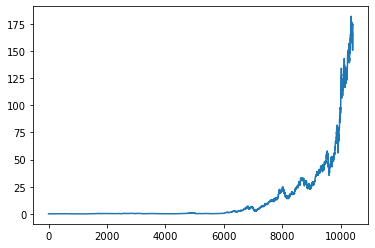

In [8]:
import matplotlib.pyplot as plt
plt.plot(days, close_price_array)

In [9]:
covid_data = spark.read.csv("../../WHO-COVID-19-global-data.csv", inferSchema=True, header=True)

In [10]:
USA_covid_data = covid_data.filter("Country_code = 'US'")

In [11]:
USA_covid_data.printSchema()

root
 |-- Date_reported: string (nullable = true)
 |-- Country_code: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- WHO_region: string (nullable = true)
 |-- New_cases: integer (nullable = true)
 |-- Cumulative_cases: integer (nullable = true)
 |-- New_deaths: integer (nullable = true)
 |-- Cumulative_deaths: integer (nullable = true)



In [12]:
covid_date_array = USA_covid_data.select(F.collect_list('Date_reported').alias('Date')).first()['Date']

In [13]:
def changeDateMode(date):
    elements = date.split('-')
    return elements[2] + '-' + elements[1] + '-' + elements[0]

In [14]:
covid_date_array = list(map(changeDateMode, covid_date_array))

In [15]:
first_day_index = 0
for i in range(0, 3):
    if covid_date_array[i] in date_array:
        first_day_index = date_array.index(covid_date_array[i])
        break

In [16]:
final_day_index = 0
for i in range(1, 4):
    if covid_date_array[len(covid_date_array) - i] in date_array:
        final_day_index = date_array.index(covid_date_array[len(covid_date_array) - i])
        break

In [17]:
first_day_index

9848

In [18]:
final_day_index

10410

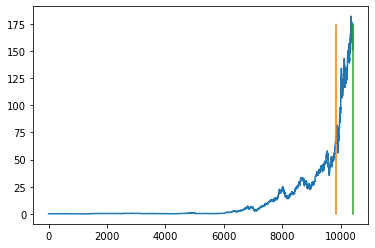

In [19]:
plt.plot(days, close_price_array, [first_day_index] * 175, [i for i in range(0, 175)], [final_day_index] * 175, [i for i in range(0, 175)])

In [20]:
close_price_array_no191 = close_price_array[191:]
pattern_interval = 365
close_price_array_in_pattern = [close_price_array_no191[i : i + pattern_interval] for i in range (0, len(close_price_array_no191), pattern_interval)]

In [21]:
import numpy as np
def sigmoidConvert(X, useStatus):
    if useStatus:
        return 1.0 / (1 + np.exp(-(X * 0.1)));
    else:
        return X;
    
def Z_ScoreNormalization(x, mean, sd):
    x = (x - mean) / sd;
    return x;

In [22]:
close_price_array_in_pattern = np.array(close_price_array_in_pattern)
norm_close_price_array_in_pattern = []
for i in range(0, len(close_price_array_in_pattern)):
    norm_close_price_array_in_pattern.append(Z_ScoreNormalization(close_price_array_in_pattern[i], close_price_array_in_pattern[i].mean(), close_price_array_in_pattern[i].std()))

In [23]:
import numpy as np
import sys
def cal_dtw_distance(ts_a, ts_b):
    """Returns the DTW similarity distance between two 2-D
    timeseries numpy arrays.

    Arguments
    ---------
    ts_a, ts_b : array of shape [n_samples, n_timepoints]
        Two arrays containing n_samples of timeseries data
        whose DTW distance between each sample of A and B
        will be compared

    d : DistanceMetric object (default = abs(x-y))
        the distance measure used for A_i - B_j in the
        DTW dynamic programming function

    Returns
    -------
    DTW distance between A and B
    """
    d = lambda x, y: abs(x - y)
    max_warping_window = 10000

    # Create cost matrix via broadcasting with large int
    ts_a, ts_b = np.array(ts_a), np.array(ts_b)
    M, N = len(ts_a), len(ts_b)
    cost = sys.maxsize * np.ones((M, N))

    # Initialize the first row and column
    cost[0, 0] = d(ts_a[0], ts_b[0])
    for i in range(1, M):
        cost[i, 0] = cost[i - 1, 0] + d(ts_a[i], ts_b[0])

    for j in range(1, N):
        cost[0, j] = cost[0, j - 1] + d(ts_a[0], ts_b[j])

    # Populate rest of cost matrix within window
    for i in range(1, M):
        for j in range(max(1, i - max_warping_window),
                       min(N, i + max_warping_window)):
            choices = cost[i - 1, j - 1], cost[i, j - 1], cost[i - 1, j]
            cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

    # Return DTW distance given window
    return cost[-1, -1]

In [24]:
close_price_when_covid = norm_close_price_array_in_pattern[27]
dtw = []
for i in range(0, len(norm_close_price_array_in_pattern)):
    dtw.append(cal_dtw_distance(close_price_when_covid, norm_close_price_array_in_pattern[i]))
print(dtw)

[93.90617469226879, 416.95298777963416, 362.701443684545, 71.68336739584036, 304.4463827370311, 243.6929996231688, 122.14806583494686, 210.4744912787884, 350.7730297121588, 247.31798861315502, 452.2488441885869, 66.15303764188295, 64.21889650296923, 424.8434353623959, 384.2007815803106, 80.14805135552737, 42.93838927254291, 69.78094597652611, 426.3487581647899, 66.93282716697198, 83.28078547557719, 301.81277728204054, 58.28813716028127, 329.0376753182734, 66.30047275634975, 170.888709388319, 74.30035639068153, 0.0]


In [25]:
import heapq
min_num_index_list = map(dtw.index, heapq.nsmallest(2, dtw))
print(list(min_num_index_list))

[27, 16]


In [26]:
min_close = min(close_price_array)
max_close = max(close_price_array)
close_price_array = np.array(close_price_array)
for i in range(len(close_price_array)):
    close_price_array[i] = (close_price_array[i] - min_close) / (max_close - min_close)
close_price_array

array([4.35483657e-04, 3.98684577e-04, 3.49613595e-04, ...,
       9.56364319e-01, 9.59936482e-01, 9.59001638e-01])

In [27]:
min_low = min(low_price_array)
max_low = max(low_price_array)
low_price_array = np.array(low_price_array)
for i in range(len(low_price_array)):
    low_price_array[i] = (low_price_array[i] - min_low) / (max_low - min_low)
low_price_array

array([4.42511865e-04, 4.05118890e-04, 3.55255959e-04, ...,
       9.50243233e-01, 9.64427523e-01, 9.60239237e-01])

In [28]:
min_open = min(open_price_array)
max_open = max(open_price_array)
open_price_array = np.array(open_price_array)
for i in range(len(open_price_array)):
    open_price_array[i] = (open_price_array[i] - min_open) / (max_open - min_open)
open_price_array

array([4.30949973e-04, 3.97331954e-04, 3.48427418e-04, ...,
       9.36630596e-01, 9.52075892e-01, 9.42710115e-01])

In [29]:
min_transaction = min(transaction_volume_array)
max_transaction = max(transaction_volume_array)
transaction_volume_array = np.array(transaction_volume_array)
for i in range(len(transaction_volume_array)):
    transaction_volume_array[i] = (transaction_volume_array[i] - min_transaction) / (max_transaction - min_transaction)
transaction_volume_array

array([0.0631981 , 0.02369891, 0.01424591, ..., 0.0121444 , 0.01084271,
       0.00701736])

In [30]:
min_high = min(high_price_array)
max_high = max(high_price_array)
high_price_array = np.array(high_price_array)
for i in range(len(high_price_array)):
    high_price_array[i] = (high_price_array[i] - min_high) / (max_high - min_high)
high_price_array

array([4.33270546e-04, 3.96658479e-04, 3.47836836e-04, ...,
       9.51883718e-01, 9.58116958e-01, 9.56613358e-01])

In [31]:
min_adjusted_close = min(adjusted_close_price_array)
max_adjusted_close = max(adjusted_close_price_array)
adjusted_close_price_array = np.array(adjusted_close_price_array)
for i in range(len(adjusted_close_price_array)):
    adjusted_close_price_array[i] = (adjusted_close_price_array[i] - min_adjusted_close) / (max_adjusted_close - min_adjusted_close)
adjusted_close_price_array

array([3.40809167e-04, 3.12010178e-04, 2.73607263e-04, ...,
       9.57585624e-01, 9.61162128e-01, 9.60226148e-01])

In [32]:
datas = np.stack((close_price_array, low_price_array, open_price_array, transaction_volume_array, high_price_array, adjusted_close_price_array), axis = 1)
print(datas)

[[4.35483657e-04 4.42511865e-04 4.30949973e-04 6.31981003e-02
  4.33270546e-04 3.40809167e-04]
 [3.98684577e-04 4.05118890e-04 3.97331954e-04 2.36989104e-02
  3.96658479e-04 3.12010178e-04]
 [3.49613595e-04 3.55255959e-04 3.48427418e-04 1.42459064e-02
  3.47836836e-04 2.73607263e-04]
 ...
 [9.56364319e-01 9.50243233e-01 9.36630596e-01 1.21444034e-02
  9.51883718e-01 9.57585624e-01]
 [9.59936482e-01 9.64427523e-01 9.52075892e-01 1.08427101e-02
  9.58116958e-01 9.61162128e-01]
 [9.59001638e-01 9.60239237e-01 9.42710115e-01 7.01735794e-03
  9.56613358e-01 9.60226148e-01]]


In [33]:
import pandas as pd
df = pd.DataFrame(datas, columns = ["close_price", "low_price", "open_price", "transaction_volume", "high_price", "adjusted_close"])
sparkdf = sqlContext.createDataFrame(df)

In [34]:
sparkdf.printSchema()

root
 |-- close_price: double (nullable = true)
 |-- low_price: double (nullable = true)
 |-- open_price: double (nullable = true)
 |-- transaction_volume: double (nullable = true)
 |-- high_price: double (nullable = true)
 |-- adjusted_close: double (nullable = true)



In [35]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import (VectorAssembler, VectorIndexer)
assembler = VectorAssembler(inputCols = ["low_price", "open_price", "transaction_volume", "high_price", "adjusted_close"], outputCol = 'features')

In [36]:
output = assembler.transform(sparkdf)
label_features = output.select("features", 'close_price').toDF('features', 'label')

In [37]:
train_data, test_data = label_features.randomSplit([0.8, 0.2])

In [38]:
label_features.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------+---------------------+
|features                                                                                                      |label                |
+--------------------------------------------------------------------------------------------------------------+---------------------+
|[4.425118649857621E-4,4.309499733540966E-4,0.06319810034460305,4.332705461604476E-4,3.4080916660338064E-4]    |4.3548365668646683E-4|
|[4.051188899742423E-4,3.9733195366275793E-4,0.023698910354163192,3.9665847939774165E-4,3.120101778772833E-4]  |3.986845767500989E-4 |
|[3.55255959161392E-4,3.4842741793291327E-4,0.01424590637692948,3.478368364379171E-4,2.7360726267733755E-4]    |3.496135954687653E-4 |
|[3.708363619489521E-4,3.606521746245647E-4,0.011647235743341283,3.63091901598848E-4,2.8560694380275827E-4]    |3.6494654203008065E-4|
|[3.8953848718668226E-4,3.789948186252808E-4,0.00989667

In [39]:
lr = LinearRegression()
lrModel = lr.fit(train_data)

In [40]:
test_results = lrModel.evaluate(test_data)
print("R2: {}".format(test_results.r2))

R2: 0.9999388033883341


In [41]:
assembler_low_price = VectorAssembler(inputCols = ["low_price"], outputCol = 'features')
output_low_price = assembler_low_price.transform(sparkdf)
label_features_low_price = output_low_price.select("features", 'close_price').toDF('features', 'label')
train_data_low_price, test_data_low_price = label_features_low_price.randomSplit([0.8, 0.2])
lrModel_low_price = lr.fit(train_data_low_price)
test_results_low_price = lrModel_low_price.evaluate(test_data_low_price)
print("R2 with low price: {}".format(test_results_low_price.r2))

R2 with low price: 0.9998065515267671


In [42]:
assembler_open_price = VectorAssembler(inputCols = ["open_price"], outputCol = 'features')
output_open_price = assembler_open_price.transform(sparkdf)
label_features_open_price = output_open_price.select("features", 'close_price').toDF('features', 'label')
train_data_open_price, test_data_open_price = label_features_open_price.randomSplit([0.8, 0.2])
lrModel_open_price = lr.fit(train_data_open_price)
test_results_open_price = lrModel_open_price.evaluate(test_data_open_price)
print("R2 with open price: {}".format(test_results_open_price.r2))

R2 with open price: 0.9997705891260886


In [43]:
assembler_transaction_volume = VectorAssembler(inputCols = ["transaction_volume"], outputCol = 'features')
output_transaction_volume = assembler_transaction_volume.transform(sparkdf)
label_features_transaction_volume = output_transaction_volume.select("features", 'close_price').toDF('features', 'label')
train_data_transaction_volume, test_data_transaction_volume = label_features_transaction_volume.randomSplit([0.8, 0.2])
lrModel_transaction_volume = lr.fit(train_data_transaction_volume)
test_results_transaction_volume = lrModel_transaction_volume.evaluate(test_data_transaction_volume)
print("R2 with transaction volume: {}".format(test_results_transaction_volume.r2))

R2 with transaction volume: 0.039584886904920236


In [44]:
assembler_high_price = VectorAssembler(inputCols = ["high_price"], outputCol = 'features')
output_high_price = assembler_high_price.transform(sparkdf)
label_features_high_price = output_high_price.select("features", 'close_price').toDF('features', 'label')
train_data_high_price, test_data_high_price = label_features_high_price.randomSplit([0.8, 0.2])
lrModel_high_price = lr.fit(train_data_high_price)
test_results_high_price = lrModel_high_price.evaluate(test_data_high_price)
print("R2 with high price: {}".format(test_results_high_price.r2))

R2 with high price: 0.9998692960237529


In [45]:
assembler_adjusted_close = VectorAssembler(inputCols = ["adjusted_close"], outputCol = 'features')
output_adjusted_close = assembler_adjusted_close.transform(sparkdf)
label_features_adjusted_close = output_adjusted_close.select("features", 'close_price').toDF('features', 'label')
train_data_adjusted_close, test_data_adjusted_close = label_features_adjusted_close.randomSplit([0.8, 0.2])
lrModel_adjusted_close = lr.fit(train_data_adjusted_close)
test_results_adjusted_close = lrModel_adjusted_close.evaluate(test_data_adjusted_close)
print("R2 with adjusted close: {}".format(test_results_adjusted_close.r2))

R2 with adjusted close: 0.9993247469783844


Feature Selection: low price > high price > open price > adjusted close > transaction volume